---
title: "Post-installation resistance in stiff clay"
subtitle: "Examining the performance of the Unified method"
author: "Kevin Duffy"
bibliography: ../bibliography.bib
format:
  html:
    code-fold: false
    code-summary: "Show code"
---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/triaduct/offshoregeotechnics/blob/main/notes/5-3_srd-clay.ipynb){target="_blank"} <nbsp>

As part of a driveability study you are required to estimate the pile capacity: 

1. Pile A: $D_{outer} =$ 762mm, $t_{shoe}=$ 51mm
2. Pile B: $D_{outer} =$ 762mm; $t =$ 32mm

This capacity should be estimated at a depth of 12m below sea level as well as at a depth of 18.3m. The digitised CPT data is available in `data/srd-clay-cpt.csv` ([link](https://github.com/triaduct/offshoregeotechnics/tree/main/notes/data)).

Pile A had a driving shoe which significantly reduced the amount of plugging (@fig-west-sole).

![Driving shoe of Pile A along with $IFR$ measurements](pics/installation/west-sole.png){#fig-west-sole width=80%}

:::{.callout-note}
This example has been taken from tests @clarkeReinterpretationWestSole1985 performed at West Sole---just off the coast of Hull in the United Kingdom. 
:::

## Check ground conditions

In [19]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

# sys.path.append("..")
# !pip install git+https://github.com/triaduct/offshoregeotechnics.git@main # Use this code to add offshoregeotechnics to your Python library 
# from utils import correlations # From the CPyT package

cpt = pd.read_csv("data/srd-clay-cpt.csv")
cpt.head(10)

,z (m),qc (MPa),fs (MPa)
0,-4.603775,4.013755,0.000000
1,-4.623775,4.030372,0.000000
2,-4.643775,4.046989,0.000000
3,-4.663775,4.063606,0.000000
4,-4.683775,4.080224,0.000000
5,-4.703775,4.096841,0.000000
6,-4.723775,4.113458,0.000000
7,-4.743775,4.130075,0.304578
8,-4.763775,4.146693,0.302093
9,-4.783775,4.163310,0.299607


We've been given a CPT starting at a depth of -4.6m and has only got measurements of $q_c$ and $f_s$. Generally the friction sleeve $f_s$ measurements don't start until a few centimetres after the $q_c$ measurements given that $q_c$ and $f_s$ are measured at different places on the ocne. 

Since no porewater pressure measurements were made, I will assume $q_t=q_c$.

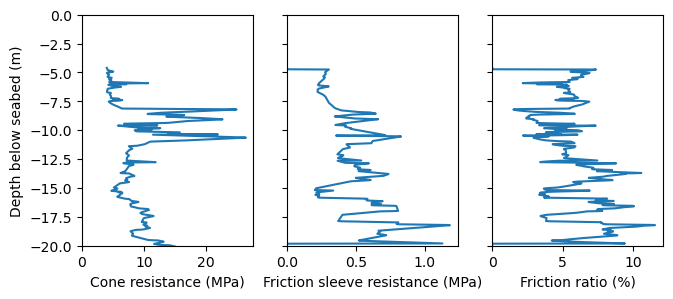

In [20]:
cpt.columns = ["z","qc","fs"] # Rename columns for simplicity
cpt["qt"] = cpt.qc  # No pore pressure measurements => no area effect
cpt["Rf"] = (cpt.fs/cpt.qc)*100


fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(7.5,3))
ax1.plot(cpt.qt,cpt.z)
ax2.plot(cpt.fs,cpt.z)
ax3.plot(cpt.Rf,cpt.z)

ax1.set_xlabel("Cone resistance (MPa)")
ax2.set_xlabel("Friction sleeve resistance (MPa)")
ax3.set_xlabel("Friction ratio (%)")
ax1.set_ylim(-20,0)
ax1.set_ylabel("Depth below seabed (m)")

for ax in [ax1,ax2,ax3]:
    ax.set_xlim(0)


Cone resistances here are surprisingly high for what is supposed to be clay, ranging from 5-10 MPa. Yet the friction ratio also seems to be representative of clay, hovering around 5%. There's potentially a clayey sand to sandy clay layer between 8m to 12m. 

We don't have pore pressure pressure measurements to check this, so let's look at the non-normalised [Robertson chart](3-3_geotechnical-investigation.ipynb#fig-rob90), since we don't have pore pressure measurements.

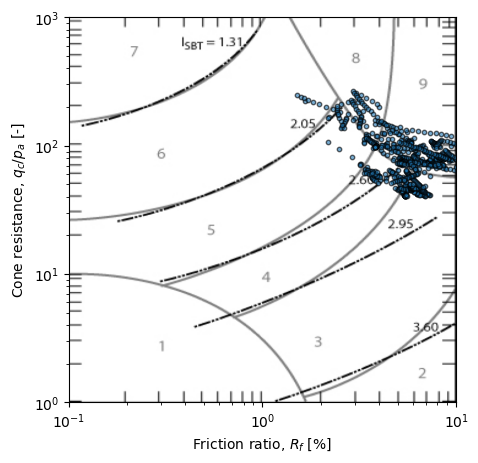

In [21]:
# Function from cpyt.interpretation.correlations (https://github.com/triaduct/cpyt/tree/main/cpyt)
def Isbt(df,plot=False,chart="robertson_1990_nonnormalised"):
    """
    Function which appends the Non-normalised soil behaviour index (see Robertson, 2010)
    :df:            The CPT information. Columns need to be labelled 
                    ["qc","fs",Rf","z"]
                     
    For in-situ effctive stresses between 50-150kPa there is little difference between the
    non-normalised I_sbt and the normalised I_c (Robertson, 2010)
    """
    if "Rf" not in df.columns:
        raise ValueError("Please add Rf first before calculating Isbt")
        
    df.fs.loc[df.fs == 0] = np.nan  # Used to hide warnings caused by np.log10
    df.Rf.loc[df.Rf == 0] = np.nan  # Used to hide warnings caused by np.log10

    pa = 0.1                        # Atmospheric pressure in MPa
    np.seterr(divide = 'ignore')    # Hide warning made by fs = 0 to make output cleaner
    df["Isbt"] = ((3.47 - np.log10(df.qc/pa))**2 + (np.log10(df.Rf)+1.22)**2)**0.5
    
    if plot:
        fig = plt.figure(figsize=(5,5))
        ax = fig.gca()
        
        # Include Robertson chart as background; Need to make adjustments as [ax] is on a log scale
        ax_tw_x = ax.twinx()
        ax_tw_x.axis('off')
        ax2 = ax_tw_x.twiny()
        img = plt.imread("../utils/images/" + chart + ".PNG")
        ax2.imshow(img,extent=[1,10,1,1000], aspect="auto")
        ax2.axis('off')
        
        if chart == "robertson_1990_nonnormalised":
            ax.scatter(df.Rf,df.qc/pa,ec="k",alpha=0.6,s=10)
        elif chart == "robertson_1986_nonnormalised":
            ax.scatter(df.Rf,df.qc,ec="k",alpha=0.6,s=10)
        ax.set_xlabel(r"Friction ratio, $R_f$ [%]")
        ax.set_ylabel(r"Cone resistance, $q_c \slash p_a$ [-]")

        if chart == "robertson_1990_nonnormalised":
            ax.set_xlim(0.1,10)
            ax.set_xticks([0.1,1,10])
            ax.set_ylim(1,1000)
            ax.set_yticks([1,10,100,1000])
            ax.set_xscale("log")
            ax.set_yscale("log")
        elif chart == "robertson_1986_nonnormalised":
            ax.set_xlim(0,8)
            # ax.set_xticks([0.1,1,10])
            ax.set_ylim(0.1,100)
            ax.set_yticks([1,10,100]) 
            ax.set_yscale("log")
        # ax.ticklabel_format(useOffset=False, style='plain')    # Don't use scientific notation
        
        ax.patch.set_facecolor('None')      # No background on axis
        ax.set_zorder(ax2.get_zorder()+1)   # Show scatter points above plot
        plt.show()
    
    return df


cpt = Isbt(cpt,plot=True,chart="robertson_1990_nonnormalised")


Clearly, most of our CPT resistances fall around Zone 3 and Zone 9—suggesting stiff clay. Importantly, we don't have sensitive clay (Zone 1), so we don't need to make any adjustments to the $F_{st}$ factor in the Unified method.

Based on what we've learned in the [marine geology section](2_marine-geology.ipynb), it's also not unusual for most of the eastern coast of the United Kingdom to have stiff clay, since all the glaciation events during the Pleistocene epoch has led to heavily overconsolidated soils. 

These CPT results also correlated well with the boreholes reported in @clarkeReinterpretationWestSole1985, although this was outside the scope of the original research question. Furthermore, there's also uncertainty regarding the clayey sand to sandy clay layer between 8m to 12m—although for the purposes of this exercise I'll just assume its pure clay for now. 

### Data processing
We're also missing some data between 0m and -4.6m. We're not told by @clarkeReinterpretationWestSole1985 as to why this was the case, so we'll just have to make a simple assumption regarding the soil properties across the interval.

I'll just perform a simple interpolation from 0m to -4.6m. For the Unified method, we only need $q_t$ so I'll only interpolate those values.

Text(24.000000000000014, 0.5, 'Depth below seabed (m)')

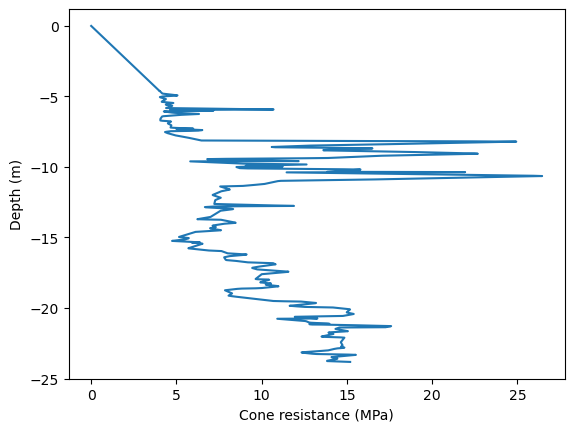

In [22]:
dz = 0.02 # Readings every 2cm
z_new = np.arange(0, cpt.z.iloc[0] - dz, -dz)
qc_new = np.linspace(0, cpt.qt.iloc[0], len(z_new))
qt_new = qc_new

cpt_to_merge = pd.DataFrame({
    "z": z_new,
    "qc": qc_new,
    "fs": np.nan,
    "Rf": np.nan,
    "qt": qt_new,
    "Isbt": np.nan
})

# Concatenate the new dataframe with the original CPT
cpt_new = pd.concat([cpt, cpt_to_merge], ignore_index=True)
cpt_new = cpt_new.sort_values("z",ascending=False).reset_index(drop=True)

fig = plt.figure()
ax = fig.gca()
ax.plot(cpt_new.qt,cpt_new.z)
ax.set_xlabel("Cone resistance (MPa)")
ax.set_ylabel("Depth (m)")
ax1.set_ylim(-20,0)
ax1.set_ylabel("Depth below seabed (m)")


## Perform calculation
The calculation was performed for a driveability study. 

$$ 
q_s = 0.07 F_{st} q_t \max[1,(h/D^*)]^{-0.25}
$$

We first need to prepare a couple of things. 

#### Pile geometries

In [23]:
D_outer_A = 0.762  # Outer diameter of Pile A, in metres
wall_thickness_A = 0.051
D_inner_A = D_outer_A - wall_thickness_A*2

D_outer_B = 0.762  # Outer diameter of Pile B, in metres
wall_thickness_B = 0.032
D_inner_B = D_outer_B - wall_thickness_B*2

#### Unified method in clay

In [24]:
def unified_clay_shaft(cpt, z_top, z_base, D_inner, D_outer):
    """
    :z_top: is the top of the pile (metres, w.r.t seabed)
    :z_base: is the bottom of the pile (metres, w.r.t seabed)
    :D_inner: is the inner pile diameter at the pile base
    :D_outer: is the outer pile diameter at the pile base
    """
    cpt = cpt.loc[(cpt.z <= z_top) & (cpt.z >= z_base)].copy()
    circumference = np.pi*D_outer
    Dstar = (D_outer**2 - D_inner**2)**0.5  

    cpt["h_D"] = (cpt.z - z_base)/Dstar
    cpt.h_D.loc[cpt.h_D < 1] = 1    # i.e. max(1, h/D)
    Fst = 1 # No sensitive clay present
    cpt["qs"] = 0.07 * Fst * (cpt.qt*1000) * cpt.h_D**-0.25   # kPa
    
    cpt["depth_diff"] = abs(cpt.z.diff())                   # Depth difference between CPT soundings
    cpt["Qsmax_contrib"] = cpt.depth_diff*circumference*cpt.qs     # Contribution of each ~2cm layer to total shear resistance
    cpt["Qsmax"] = cpt.Qsmax_contrib.cumsum()

    cpt.reset_index(drop=True,inplace=True)
    near_z_ix = cpt.z.sub(z_base).abs().idxmin()        # Index of row with depth closest to pile depth
    Qsmax = cpt.Qsmax.iloc[near_z_ix]                   # Shaft capacity in kN
    
    # print(f"The pile shaft capacity is {Qsmax:.0f} kN")
    return Qsmax


In [25]:
def unified_clay_base(cpt, z_base, D_inner, D_outer, FFR=None):
    """
    :z_base: is the bottom of the pile (metres, w.r.t seabed)
    :D_inner: is the inner pile diameter at the pile base
    :D_outer: is the outer pile diameter at the pile base
    :FFR: provides an option to override the Final Filling Ratio (FFR) if needed
    """
    area = np.pi*(D_outer/2)**2
    # A_ann = np.pi*(D_outer/2)**2 - np.pi*(D_inner/2)**2
    
    if FFR == None:
        # If no FFR specified, then performed the Unified prediction
        d_cpt = 35.7e-3 #diameter of a CPT cone [m]
        PLR = np.tanh(0.3*(D_inner/d_cpt)**0.5)
        FFR = PLR   # Assuming FFR is approx. equal to PLR
    A_re = 1 - FFR*(D_inner/D_outer)**2
    
    near_z_ix = cpt.z.sub(z_base).abs().idxmin()       # Index of row with depth closest to pile depth
    qt_tip = cpt.loc[near_z_ix, "qt"]
    # qb01 = (0.20 + 0.60*A_re)*qt_tip    # Base stress [kPa]
    qb01 = 0.4*qt_tip    # Base stress for open-ended pile [kPa]
    Qbase = (qb01*1000*area)       # Max pile tip capacity [kN]

    # print(f"The pile base capacity at {z_base:.2f} m is {Qbase:.2f} kN")
    return Qbase


#### Final calculation

In [26]:
for z_base in [-12,-18.3]:
    print("_____________________")
    print(f"At a depth of {z_base}m:")
    Qs_A = unified_clay_shaft(cpt_new, z_top=0, z_base=z_base, D_inner=D_inner_A, D_outer=D_outer_A)
    Qb_A = unified_clay_base(cpt_new, z_base=z_base, D_inner=D_inner_A, D_outer=D_outer_A, FFR=None)
    print(f"Capacity of Pile A is {Qs_A:.0f} (Qs) + {Qb_A:.0f} (Qb) = {Qs_A + Qb_A:.0f}kN")
    
    Qs_B = unified_clay_shaft(cpt_new, z_top=0, z_base=z_base, D_inner=D_inner_B, D_outer=D_outer_B)
    Qb_B = unified_clay_base(cpt_new, z_base=z_base, D_inner=D_inner_B, D_outer=D_outer_B, FFR=None)
    print(f"Capacity of Pile B is {Qs_B:.0f} (Qs) + {Qb_B:.0f} (Qb) = {Qs_B + Qb_B:.0f}kN")

_____________________
At a depth of -12m:
Capacity of Pile A is 8194 (Qs) + 1304 (Qb) = 9498kN
Capacity of Pile B is 7778 (Qs) + 1304 (Qb) = 9082kN
_____________________
At a depth of -18.3m:
Capacity of Pile A is 11379 (Qs) + 1896 (Qb) = 13275kN
Capacity of Pile B is 10802 (Qs) + 1896 (Qb) = 12697kN


@fig-clarke-results shows the results of load tests performed on the same piles, including both load tests in compression and load tests in tension, performed a different times during pile installation. Clearly the Unified method has overestimated the capacities by quite a lot!

![Results from @clarkeReinterpretationWestSole1985](pics/installation/clarke95-table3.png){#fig-clarke-results}

But is this surprising? Not totally.

The Unified method is designed for a pile capacity after 14 days whereas the pile tests by @clarkeReinterpretationWestSole1985 were performed anywhere between three to eight hours after installation. As we saw from the [section on piles in clay](5-1_mechanisms-clay.ipynb), post-installation consolidation will have a huge effect on the pile capacity. 

For instance, @fig-jardine23 shows the shaft capacity measured at Tilbrook (highly overconsolidated clay) was roughly 75% of that predicted by the Unified method, even as low as 40% in lightly overconsolidated clay.  

![Comparison of the measured shaft capacity $Q_s$ to that predicted by the Unified method for load tests performed over differsent times [@clarkeReinterpretationWestSole1985]](pics/axial/jardine23.png){#fig-jardine23}

Generally, clay is not a huge issue for driveability problems---a least not compared to very dense sand and so predicting the SRD response in clay is not as much prioritised compared to sand. But this example could open avenues towards making several adjustments, including in terms of aging factor, how plugging is accounted for and the displacement for which the method is design.